In [65]:
import os
import sqlite3 as sqlite
import numpy as np
import pandas as pd
import pickle
import scipy
import matplotlib.pyplot as plt

This notebook works when starting like this:
```bash
cd mag_sample
conda activate science-career-tempenv
env PYTHONPATH=/absolute/path/to/mag_sample/src/dataprep/ juptyer-lab --no-browser
```

or probably with VS code

### Load data

In [3]:
from main.link.fit_svd_model import MODEL_URL, make_sparse, run_svd
from helpers.variables import db_file
max_level = 2

In [4]:
sqlite.register_adapter(np.int64, lambda val: int(val))
con = sqlite.connect(database=db_file, isolation_level=None)

In [13]:
with open(MODEL_URL + ".pkl", "rb") as f:
    svd_model = pickle.load(f)

In [5]:
con.execute(
        """CREATE TEMP TABLE fields_to_max_level AS
        SELECT FieldOfStudyId
        FROM FieldsOfStudy
        WHERE Level > 0 AND Level <= (?)
        """
        , (max_level,)
        )
con.execute("CREATE UNIQUE INDEX idx_temp1 ON fields_to_max_level(FieldOfStudyId ASC)") # TODO: need to query this without overwriting the table `valid_papers`

In [17]:
sql_papers = """
SELECT PaperId, FieldOfStudyId, Score
FROM PaperFieldsOfStudy
INNER JOIN (
    SElECT PaperId
    FROM valid_papers
    ORDER BY RANDOM()
    LIMIT 10000
)
USING (PaperId)
INNER JOIN fields_to_max_level USING(FieldOfStudyId)
"""

In [18]:
papers_concepts = pd.read_sql(sql_papers, con)

In [99]:
papers_concepts["PaperId"].nunique()

9192

In [100]:
assert papers_concepts.drop_duplicates(subset=["PaperId", "FieldOfStudyId"]).shape == papers_concepts.shape

In [101]:
fields_of_study = pd.read_sql("SELECT * FROM fields_to_max_level ORDER BY FieldOfStudyId", con=con) # TODO: refactor this; add it do the function that loads the data?

In [20]:
field_to_index = {id: index for index, id in enumerate(fields_of_study['FieldOfStudyId'].unique())}


### Compute embeddings

In [49]:
papers_concepts_sparse, row_to_index = make_sparse(
    papers_concepts, field_to_index, "PaperId", "FieldOfStudyId", "Score")

svd, embs = run_svd(papers_concepts_sparse, 1024, svd_model) # TODO: need to refactor! n_components not necessary! also don't print out the fitting stats when just transforming

(46398,)
<9192x137480 sparse matrix of type '<class 'numpy.float64'>'
	with 46398 stored elements in Compressed Sparse Row format>
Original matrix shape: (9192, 137480)
Reduced matrix shape: (9192, 1024)
Explained variance ratio: 0.5472


In [22]:
embs.shape

(9192, 1024)

In [70]:
embs.max()

0.8257507897916694

In [96]:
papers_concepts.head()
paper_ids = papers_concepts["PaperId"].unique()


### Sanity checks

#### KNN classification check

In [44]:
q_paper_id = [x for x in paper_ids]
qmarks_paper_id = ",".join(["?" for _ in paper_ids])

In [40]:
sql_main_field = f"""
SELECT PaperId, Field0
FROM PaperMainFieldsOfStudy
WHERE PaperId IN ({qmarks_paper_id})"""

In [45]:
papers_main_field = pd.read_sql(sql_main_field, con, params=q_paper_id)

In [46]:
papers_main_field.head()

,PaperId,Field0
0,600888,144024400
1,1788564,41008148
2,2021061,185592680
3,3019212,144133560
4,3035123,71924100


In [54]:
labels = papers_main_field["Field0"].values
paper_ids = papers_main_field["PaperId"].values
x_full = []
x_reduced = []


In [55]:
for paperid in paper_ids:
    row_index = row_to_index[paperid]
    x_full.append(papers_fields_sparse[row_index, :])
    x_reduced.append(embs[row_index, :])

In [56]:
x_full = scipy.sparse.vstack(x_full)
x_reduced = np.array(x_reduced)

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [59]:
n_neighbors = 50
neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
# neigh_reduced = KNeighborsClassifier(n_neighbors=n_neighbors)

In [103]:
scores = cross_val_score(neigh, x_full, labels, cv=5)
print(f"cv scores on full dataset: {scores}")

cv scores on full dataset: [0.39151713 0.43393148 0.45375408 0.35908596 0.35418934]


In [104]:
scores = cross_val_score(neigh, x_reduced, labels, cv=5)
print(f"cv scores on reduced dataset: {scores}")

cv scores on reduced dataset: [0.66122893 0.66231648 0.66322089 0.60718172 0.6523395 ]


#### Cosine similarity check

In [81]:
def cosine_similarity(m, i, j):
    a = m[i]
    b = m[j]
    ab = (a @ b.T)
    if isinstance(ab, scipy.sparse._csr.csr_matrix):
        ab = ab.toarray()
        a = a.toarray()
        b = b.toarray()

    denominator = (np.power(a, 2).sum() * np.power(b, 2).sum() + 0.001)
    denominator = np.sqrt(denominator)
    return ab / denominator


In [85]:
n = 5000
sim_full = []
sim_reduced = []
for _ in range(n):
    n_vectors = papers_fields_sparse.shape[0]
    i, j = np.random.choice(np.arange(n_vectors), 2)
    while i == j:
        i, j = np.random.choice(np.arange(n_vectors), 2)
    sim = cosine_similarity(papers_fields_sparse, i, j)
    sim_full.append(sim[0][0])
    sim = cosine_similarity(embs, i, j)
    sim_reduced.append(sim)

sim_full = np.array(sim_full)
sim_reduced = np.array(sim_reduced)
    

In [90]:
np.abs(sim_full).min()
np.abs(sim_reduced).min()

0.0

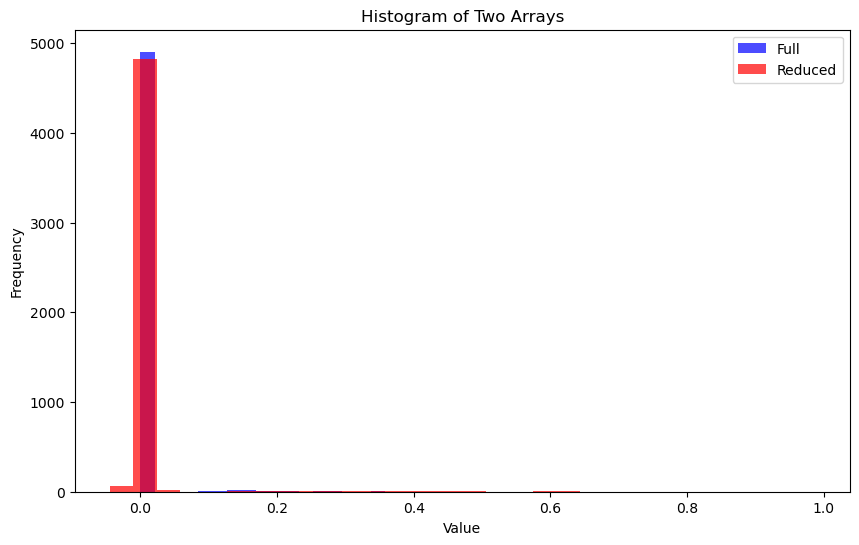

In [88]:
plt.figure(figsize=(10, 6))
plt.hist(sim_full, bins=30, alpha=0.7, color='blue', label='Full')
plt.hist(sim_reduced, bins=30, alpha=0.7, color='red', label='Reduced')
# Customize the plot
plt.title('Histogram of Two Arrays')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Display the plot
plt.show()
